##まとめ
* 翻訳や音声認識など、ある時系列データを別の時系列データに変換するタスクでは、時系列データ間に対応関係が存在することが多くある
* Attentionは２つの時系列データ間の対応関係をデータから学習する
* Attentionでは（一つの方法として）ベクトルの内積を使ってベクトル間の類似度を計算し、その類似度を用いた重み付き和ベクトルがAttentionの出力となる
* Attentionで使用する演算は微分可能なため、誤差逆伝搬法を用いて学習ができる
* Attentionが算出する重み（確率）を可視化することで、入出力の対応関係を見ることができる
* 外部メモリによるニューラルネットワークの拡張の研究例では、メモリの読み書きにAttentionが用いられる

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL_2'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


##Attentionの仕組み

###seq2seqの問題点
* Encoderの出力が固定長のベクトルである

###Encoderの改良
* 各時刻のLSTMレイヤの隠れ状態ベクトルをすべて利用する

###Decoderの改良①
* Encoderは、各単語に対応するLSTMレイヤの隠れ状態ベクトルをhsとしてまとめて出力する
* hsはDecoderに渡され、時系列変換が行われる
* 「入力と出力でどの単語が関連しているのか」といった対応関係をseq2seqに学習させる
* 単語間（もしくはフレーズ間）の対応関係を表す情報のことをアライメント（alignment）という
* Attentionはアライメントのアイデアをseq2seqに自動で取り入れることに成功した
* 単語のアライメント抽出とは、各時刻においてDecoderへの入力単語と対応関係にある単語のベクトルをhsから選び出すこと
* 「選ぶ」ということを微分可能な計算で置き換えるには、各単語の重要度（貢献度）を表す重みを別途計算する
* 各単語の重要度を表す重みaは確率分布と同じく0.0から1.0までのスカラーであり、その総和は1になる
* 重みaと各単語のベクトルhsから、その重み付き和を求めることで目的とするベクトルである「コンテキストベクトル」cを得る
* コンテキストベクトルには現時刻の翻訳をするために必要な情報が含まれている


In [ ]:
import numpy as np

T,H=5,4
hs=np.random.randn(T,H)
print('hs.shape:',hs.shape,'\n',hs)
a=np.array([0.8,0.1,0.03,0.05,0.02])
print('\na\n',a)
ar=a.reshape(5,1).repeat(H,axis=1)
print('\nar.shape:',ar.shape,'\n',ar)

t=hs*ar
print('\nt.shape:',t.shape,'\n',t)

c=np.sum(t,axis=0)
print('\nc.shape:',c.shape,'\n',c)

hs.shape: (5, 4) 
 [[-0.42218346 -0.48682407 -0.90970958  0.06447373]
 [-0.31525869  0.0820184   1.48109113  0.89335978]
 [-2.92369975  1.20388678  0.32746059 -2.26066964]
 [ 0.00566992  1.29087697  1.07619332  0.23236563]
 [ 1.03719253  1.0407436   1.10205737 -1.18084942]]

a
 [0.8  0.1  0.03 0.05 0.02]

ar.shape: (5, 4) 
 [[0.8  0.8  0.8  0.8 ]
 [0.1  0.1  0.1  0.1 ]
 [0.03 0.03 0.03 0.03]
 [0.05 0.05 0.05 0.05]
 [0.02 0.02 0.02 0.02]]

t.shape: (5, 4) 
 [[-3.37746765e-01 -3.89459256e-01 -7.27767662e-01  5.15789807e-02]
 [-3.15258688e-02  8.20183967e-03  1.48109113e-01  8.93359782e-02]
 [-8.77109924e-02  3.61166034e-02  9.82381776e-03 -6.78200892e-02]
 [ 2.83495970e-04  6.45438487e-02  5.38096661e-02  1.16182815e-02]
 [ 2.07438506e-02  2.08148720e-02  2.20411474e-02 -2.36169884e-02]]

c.shape: (4,) 
 [-0.43595628 -0.25978209 -0.49398392  0.06109616]


In [ ]:
import numpy as np

N,T,H=3,5,4
hs=np.random.randn(N,T,H)
print('hs.shape:',hs.shape,'\n',hs)
a=np.random.randn(N,T)
print('\na.shape',a.shape,'\n',a)
ar=a.reshape(N,T,1).repeat(H,axis=2)
print('\nar.shape:',ar.shape,'\n',ar)

t=hs*ar
print('\nt.shape:',t.shape,'\n',t)

c=np.sum(t,axis=1)
print('\nc.shape:',c.shape,'\n',c)

hs.shape: (3, 5, 4) 
 [[[-0.34497015 -0.89584677  0.55890523 -1.11972215]
  [ 1.46302756  0.5924558  -0.45876966  2.16371085]
  [-0.56663537  2.01495766  1.52184249  2.64130923]
  [ 0.05406786  1.18394156  0.73303566  1.70421083]
  [ 0.67204929 -1.60985011 -1.1805897   1.5494032 ]]

 [[-1.49410503 -0.41047264  1.92612772  0.58030243]
  [-1.29312573  0.26983701 -2.22739939  0.77368702]
  [ 0.80859998 -0.2224096  -2.18154091  1.96750151]
  [ 0.88370988 -0.46099191  0.68247067  0.89489799]
  [-1.31731501 -1.02839687 -0.24948659 -1.46684038]]

 [[ 0.87956911 -0.40672941 -0.22285963 -0.81732804]
  [ 1.02896002  0.04538457  0.41793299 -0.73972154]
  [-0.07829648 -0.40707376  0.86482307  0.84711132]
  [ 0.93182873 -0.70017182 -0.25534558 -0.57225511]
  [-0.32719614  0.04997723  0.24648899 -1.48363098]]]

a.shape (3, 5) 
 [[-0.64251196 -0.24369555  0.49414938 -0.28964039 -1.51405037]
 [ 1.42697793  0.58101922 -1.75420629 -0.61438634 -0.41352536]
 [-0.13146755  0.29165174  1.32125864  0.2485241

In [ ]:
from common.np import *  # import numpy as np

class WeightSum:
    def __init__(self):
        self.params,self.grads=[],[]
        self.cache=None

    def forward(self,hs,a):
        N,T,H=hs.shape
        ar=a.reshape(N,T,1).repeat(H,axis=2)
        t=hs*ar
        c=np.sum(t,axis=1)
        self.cache=(hs,ar)
        return c

    def backward(self,dc):
        hs,ar=self.cache
        N,T,H=hs.shape
        dt=dc.reshape(N,1,H).repeat(T,axis=1)
        dar=dt*hs
        dhs=dt*ar
        da=np.sum(dar,axis=2)
        return dhs,da

###Decoderの改良②
* 各単語の重要度を表す重みaを得る方法のひとつに、Encoderが出力した隠れ状態ベクトルhsと、Decoderの各レイヤ（各単語）が出力した隠れ状態ベクトルhの、ベクトル間の類似度を内積によって計算する方法がある

In [ ]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N,T,H=3,5,4
hs=np.random.randn(N,T,H)
h=np.random.randn(N,H)
hr=h.reshape(N,1,H).repeat(T,axis=1)    #時系列方向に複製
t=hs*hr #t.shapeは(N,T,H)
print('t.shape:',t.shape)
s=np.sum(t,axis=2)  #s.shapeは(N,T)、各単語の重要度を表すスコア
softmax=Softmax()
a=softmax.forward(s)    #aは各単語の重要度を表す重み（確率分布）
print('a.shape:',a.shape)

t.shape: (3, 5, 4)
a.shape: (3, 5)


In [ ]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params,self.grads=[],[]
        self.softmax=Softmax()
        self.cache=None

    def forward(self,hs,h):
        N,T,H=hs.shape

        hr=h.reshape(N,1,H).repeat(T,axis=1)    #Decoderの出力h（最後のLSTMレイヤの隠れ状態ベクトル）を(N,T,H)の形に拡張する
        t=hs*hr #Encoderの隠れ状態ベクトルとDecoderの隠れ状態ベクトル間の類似度を内積で求める(N,T,H)×(N,T,H)
        s=np.sum(t,axis=2)  #(N,T,H)を(N,T)の形に集約して単語ごとの重要度を表すスコアを求める
        a=self.softmax.forward(s)   #softmax関数を適用し、単語ごとの重要度を表す確率分布を求める

        self.cache=(hs,hr)
        return a

    def backward(self,da):
        hs,hr=self.cache
        N,T,H=hs.shape

        ds=self.softmax.backward(da)
        dt=ds.reshape(N,T,1).repeat(H,axis=2)
        dhs=dt*hr
        dhr=dt*hs
        dh=np.sum(dhr,axis=1)   #時系列方向に集約して(N,H)の形にする

        return dhs,dh

###Decoderの改良③
* Encoderが出力する各単語のベクトルhsに対してAttention Weightレイヤが注意を払い、各単語の重みaを求める
* それに続き、Weight Sumレイヤがaとhsの重み付き和を求め、それをコンテキストベクトルcとして出力する
* Weight Sumレイヤ＋Attention WeightレイヤをAttentionレイヤとし、LSTMレイヤとAffineレイヤの間に挿入する
* AffineレイヤにはLSTMレイヤの隠れ状態ベクトルにAttentionレイヤからのコンテキストベクトルを追加する形で入力する

In [ ]:
from common.np import *  # import numpy as np

class Attention:
    def __init__(self):
        self.params,self.grads=[],[]
        self.attention_weight_layer=AttentionWeight()
        self.weight_sum_layer=WeightSum()
        self.attention_weight=None

    def forward(self,hs,h):
        a=self.attention_weight_layer.forward(hs,h)
        c=self.weight_sum_layer.forward(hs,a)
        self.attention_weight=a
        return c

    def backward(self,dc):
        dhs0,da=self.weight_sum_layer.backward(dc)
        dhs1,dh=self.attention_weight_layer.backward(da)
        dhs=dhs0+dhs1
        return dhs,dh

In [ ]:
from common.np import *  # import numpy as np

class TimeAttention:
    def __init__(self):
        self.params,self.grads=[],[]
        self.layers=None
        self.attention_weights=None

    def forward(self,hs_enc,hs_dec):
        N,T,H=hs_dec.shape
        out=np.empty_like(hs_dec)
        self.attention_weights=[]
        self.layers=[]
        for t in range(T):
            layer=Attention()
            out[:,t,:]=layer.forward(hs_enc,hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self,dout):
        N,T,H=dout.shape
        dhs_enc=0
        dhs_dec=np.empty_like(dout)

        for t in range(T):  #逆伝搬時は時系列方向のつながりを断ち切り（Truncated BPTT）、それぞれ求めた勾配は加算するため順不同
            layer=self.layers[t]
            dhs,dh=layer.backward(dout[:,t,:])
            dhs_enc+=dhs
            dhs_dec[:,t,:]=dh

        return dhs_enc,dhs_dec

##Attention付きseq2seqの実装

###Encoderの実装

In [ ]:
from ch07.seq2seq import Encoder

class AttentionEncoder(Encoder):
    def forward(self,xs):
        xs=self.embed.forward(xs)
        hs=self.lstm.forward(xs)    #hs.shapeは(N,T,H)

        return hs

    def backward(self,dhs):
        dout=self.lstm.backward(dhs)
        dout=self.embed.backward(dout)
        return dout

###Decoderの実装

In [ ]:
from common.time_layers import *
from common.np import *  # import numpy as np

class AttentionDecoder:
    def __init__(self,vocab_size,wordvec_size,hidden_size):
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn

        #重みの初期化
        embed_W=(rn(V,D)/100).astype('f')
        lstm_Wx=(rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh=(rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b=np.zeros(4*H).astype('f')
        affine_W=(rn(H+H,V)/np.sqrt(H+H)).astype('f')   #Attentionレイヤからのコンテキストベクトル(N,T,H)とLSTMレイヤからの隠れ状態ベクトル(N,T,H)が結合されたものが入力されるため、重みの形状は(2H,V)
        affine_b=np.zeros(V).astype('f')

        #レイヤの生成
        self.embed=TimeEmbedding(embed_W)
        self.lstm=TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=True)
        self.attention=TimeAttention()
        self.affine=TimeAffine(affine_W,affine_b)
        self.layers=[self.embed,self.lstm,self.attention,self.affine]

        #パラメータの格納
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def forward(self,xs,enc_hs):
        h=enc_hs[:,-1]  #Encoderからの隠れ状態ベクトルhsの最終行をDecoderのLSTMレイヤに入力,h(N,H)
        self.lstm.set_state(h)

        out=self.embed.forward(xs)
        dec_hs=self.lstm.forward(out)
        c=self.attention.forward(enc_hs,dec_hs)
        out=np.concatenate((c,dec_hs),axis=2)
        score=self.affine.forward(out)
        return score

    def backward(self,dscore):
        dout=self.affine.backward(dscore)
        N,T,H2=dout.shape
        H=H2//2

        dc,ddec_hs0=dout[:,:,:H],dout[:,:,H:]
        denc_hs,ddec_hs1=self.attention.backward(dc)
        ddec_hs=ddec_hs0+ddec_hs1
        dout=self.lstm.backward(ddec_hs)
        dh=self.lstm.dh
        denc_hs[:,-1]+=dh   #Encoderの出力の勾配の最終行に、DecoderのLSTMに入力したhの勾配を加える
        self.embed.backward(dout)

        return denc_hs

    def generate(self,enc_hs,start_id,sample_size):
        sampled=[]
        sample_id=start_id
        h=enc_hs[:,-1]
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x=np.array([sample_id]).reshape((1,1))
            out=self.embed.forward(x)
            dec_hs=self.lstm.forward(out)
            c=self.attention.forward(enc_hs,dec_hs)
            out=np.concatenate((c,dec_hs),axis=2)
            score=self.affine.forward(out)

            sample_id=np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

###seq2seqの実装

In [ ]:
from ch07.seq2seq import Encoder,Seq2seq

class AttentionSeq2seq(Seq2seq):
    def __init__(self,vocab_size,wordvec_size,hidden_size):
        args=vocab_size,wordvec_size,hidden_size
        self.encoder=AttentionEncoder(*args)
        self.decoder=AttentionDecoder(*args)
        self.softmax=TimeSoftmaxWithLoss()

        self.params,self.grads=[],[]
        self.params=self.encoder.params+self.decoder.params
        self.grads=self.encoder.grads+self.decoder.grads

##Attentionの評価

###Attention付きseq2seqの学習

In [ ]:
import sys
sys.path.append('..')
# import numpy as np
# from common.config import GPU
# GPU=True
from common.np import *
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

#データの読み込み
(x_train,t_train),(x_test,t_test)=sequence.load_data('date.txt')
char_to_id,id_to_char=sequence.get_vocab()

#入力文を反転
x_train,x_test=x_train[:,::-1],x_test[:,::-1]

#ハイパーパラメータの設定
vocab_size=len(char_to_id)
wordvec_size=16
hidden_size=256
batch_size=128
max_epoch=10
max_grad=5.0

model=AttentionSeq2seq(vocab_size,wordvec_size,hidden_size)
optimizer=Adam()
trainer=Trainer(model,optimizer)

acc_list=[]
for epoch in range(max_epoch):
    trainer.fit(x_train,t_train,max_epoch=1,batch_size=batch_size,max_grad=max_grad)
    correct_num=0
    for i in range(len(x_test)):
        question,correct=x_test[[i]],t_test[[i]]
        verbose=i<10    #10個まで評価を表示する
        correct_num+=eval_seq2seq(model,question,correct,id_to_char,verbose,is_reverse=True)
    acc=float(correct_num)/len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%'%(acc*100))
    
model.save_params(ROOT_PATH+'/ch08/Attention.pkl')

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08


KeyboardInterrupt: ignored

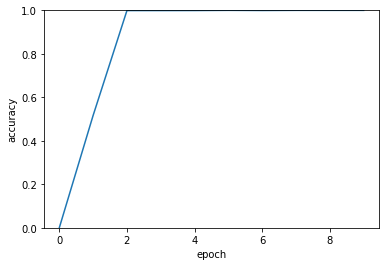

In [ ]:
import matplotlib.pyplot as plt

x=range(len(acc_list))
y=acc_list

plt.plot(x,y)
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

###Attentionの可視化

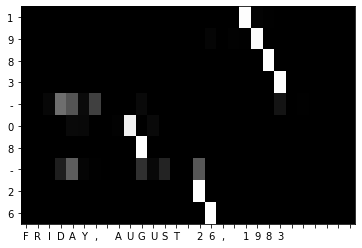

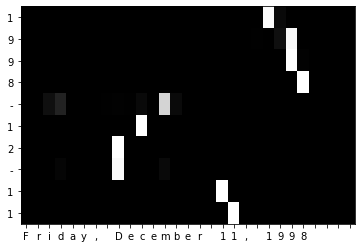

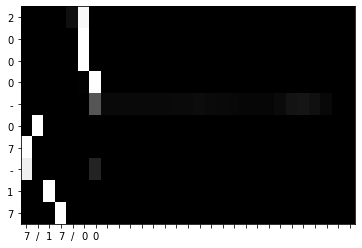

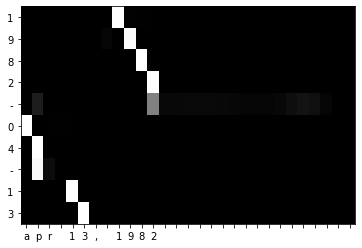

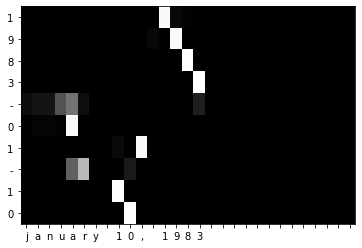

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力データの反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params(ROOT_PATH+'/ch08/Attention.pkl')

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    fig.set_facecolor('w')
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]
    # print(x.shape)
    # print(t.shape)

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d) #attention_weightsをarray化したdの形状は(Encoderの時系列数,バッチサイズ,Decoderの時系列数)
    # print(d.shape)
    attention_map = d.reshape(d.shape[0], d.shape[2])   #attention_weightsを(Encoderの時系列数,Decoderの時系列数)の形状に変換

    # 反転した入力データを表示用にもとの並びに戻す
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]   #文字IDを文字に変換
    column_labels = column_labels[1:]   #正解の先頭の文字(_)以外をラベルにする

    visualize(attention_map, row_labels, column_labels)

##Attentionに関するのこりのテーマ

###双方向RNN（LSTM）
* 通常のRNNでは文を左から右に読んでいるため、注目している単語の左側の単語の情報しかエンコードされない
* これを注目している単語の「周囲」の単語の情報をバランス良くエンコードしたい
* 双方向RNNでは、通常のRNNに加え、逆方向に（右から左に）処理するRNNを追加する
* そして各時刻において２つのRNNレイヤの隠れ状態を連結し、それを最終的な隠れ状態ベクトルとする  
    （連結以外にも和や平均が考えられる）
* ひとつのRNNレイヤにはこれまで通り、左から右方向の並びとして入力する一方、もう一つのRNNレイヤには入力文の単語を右から左方向の並びとして入力する

In [ ]:
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])    #入力を反転
        o2 = o2[:, ::-1]    #o2は右から左へ処理した結果が入っているため、もとの並びに戻す

        out = np.concatenate((o1, o2), axis=2) #順方向に処理した結果と逆方向に処理した結果を結合する,out.shape(N,T,2*H)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2   #dhs.shape(N,T,2*H)
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

###Attentionレイヤの使用方法
* Attentionレイヤの出力であるコンテキストベクトルを次時刻のLSTMレイヤへの入力とする方法もある
* こうすることでLSTMレイヤがコンテキストベクトルの情報を利用することができる
* 実装の観点からは、LSTMレイヤとAffineレイヤの間にAttentionレイヤを挿入するほうが楽

###seq2seqの深層化とskipコネクション
* LSTMレイヤを深層化する場合は、EncoderとDecoderのLSTMレイヤの数を同じにするのが一般的
* レイヤを深くするときには、汎化性能を落とさないことが重要であり、Dropoutや重み共有などの技術が有効
* skipコネクションは「層をまたぐ接続」であり、skipコネクションの接続部においては２つの出力が加算される
* 加算であるため、逆伝搬時には勾配をそのまま流すだけであり、勾配の消失（または爆発）を抑制できる

##Attentionの応用

###Google Neural Machine Translation(GNMT)
* 「ルールベース翻訳」→「用例ベース翻訳」→「統計ベース翻訳」→「ニューラル翻訳」
* seq2seqを用いた機械翻訳の総称をニューラル翻訳という
* GNMTはGoogleのニューラル翻訳を用いた機械翻訳システム
* GNMTはEncoderとDecoder、Attentionから構成されている
* GNMTではLSTMレイヤの多層化、双方向LSTM（Encoderの１層目のみ）、skipコネクション、複数GPUによる並列分散処理が行われている
* 他にも、低頻出単語の対応や、推論時の高速化のための量子化などのテクニックが用いられている

###Transformer
* RNNの欠点として、時間方向で並列的に計算することが（基本的には）できない点がある
* RNNを避けたいというモチベーションが生まれる
* RNNを取り除く研究の中で有名なものにTransformerというモデルがある
* Transformerは『Attention is all you need』というタイトルの論文で提案された手法
* TransformerはAttentionによって構成されるが、そのなかでもSelf Attentionというテクニックが利用される点が重要なポイント
* Self Attentionはふたつの時系列データ間の対応関係を求めるのではなく、ひとつの時系列データ内における各要素間の対応関係を求める
* TransformerではRNNの代わりにAttentionが使われ、EncoderとDecoderの両方でSelf Attentionが使われる
* Transformerを用いることで、計算量を抑え、GPUによる並列計算の恩恵をより多く受けることができる
* TransformerはGNMTに比べ大幅に学習時間を減らすことに成功し、精度の観点でも精度向上を実現した

###Neural Turing Machine(NTM)
* Attention付きseq2seqでは、AttentionによってEncoderとDecoderはコンピュータで言うところのメモリ操作を行っている
* Encoderが必要な情報をメモリに書き込み、Decoderがそのメモリにある情報から必要な情報を読み込んでいると解釈できる
* Attentionを使ってメモリから必要な情報を読み書きさせるための研究として有名なものにNTM（Neural Turing Machine）がある
* NTMはDeepMindのチームによって行われた研究で、後にDNC（Differentiable Neural Computers）と呼ばれる手法へと改良され、その技術論文は科学雑誌『Nature』へ掲載された
* NTMは外部メモリに対して読み書きを行いながら、時系列データを処理する
* NTMではそのようなメモリ操作を微分可能な計算で構築しているため、メモリ操作の手順をデータから学習することが可能になっている
* NTMのメモリ操作は、コンピュータのメモリ操作を模倣するために、「コンテンツベースのAttention」と「位置ベースのAttention」という２つのAttentionを利用する
* 「コンテンツベースのAttention」は、あるベクトル（クエリベクトル）に対して、それに似たベクトルをメモリ内から見つける用途で使用される
* 「位置ベースのAttention」は、前時刻に注目したメモリの位置（＝メモリの各位置に対する重み）に対して、その前後に移動（シフト）するような用途で使われる
* NTMはseq2seqが解けなかった長い時系列を記憶する問題や、ソート（＝数を大きい順に並べる）問題を解くことに成功した